# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip install --quiet wandb

In [3]:
!pip install --quiet --pre timm

In [4]:
!wandb login 38797e5fb1be476dd3af2891a6182c18cfd5a10a

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import wandb
wandb.init(project='ISIC_2024')
wandb.run.name = 'efficient-b0_lr-0.001_Adam'

wandb: Currently logged in as: 9-coding-lab (9-coding). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240817_024607-4as83gu2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run breezy-bush-37
wandb: ⭐️ View project at https://wandb.ai/9-coding/ISIC_2024
wandb: 🚀 View run at https://wandb.ai/9-coding/ISIC_2024/runs/4as83gu2


In [6]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

import torchvision.models as models
from sklearn.metrics import roc_auc_score

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [7]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [10]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [11]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [12]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

        df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
filtered> (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...


In [13]:
df.shape[0], df.target.sum()

(8253, 393)

In [14]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

10316

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [15]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [16]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [18]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [19]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

model = ISICModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);
wandb.watch(model, log="all")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

[]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [20]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    all_targets = []
    all_outputs = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        #running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        #epoch_auroc = running_auroc / dataset_size
        all_outputs.extend(outputs.cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])
    epoch_auroc = roc_auc_score(all_targets, all_outputs)
    gc.collect()
    
    
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [22]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    epoch_loss = None
    epoch_auroc = None
    all_targets = []
    all_outputs = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#        epoch_auroc = running_auroc / dataset_size
        all_outputs.extend(outputs.cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, #Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])   
    epoch_auroc = roc_auc_score(all_targets, all_outputs)
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "/kaggle/working/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        wandb.log({
            'Train Loss': train_epoch_loss,
            'Valid Loss': val_epoch_loss,
            'Train AUROC': train_epoch_auroc,
            'Valid AUROC': val_epoch_auroc
        })
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [24]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [25]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [26]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [27]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [28]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 26/26 [00:08<00:00,  2.96it/s, Epoch=1, LR=0.001, Valid_Loss=0.956]


Validation AUROC Improved (-inf ---> 0.6836811930299224)
Model Saved



100%|██████████| 26/26 [00:07<00:00,  3.64it/s, Epoch=2, LR=0.001, Valid_Loss=0.577]


Validation AUROC Improved (0.6836811930299224 ---> 0.8682239829935261)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.96it/s, Epoch=3, LR=0.001, Valid_Loss=0.538]


Validation AUROC Improved (0.8682239829935261 ---> 0.8914548909717525)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.82it/s, Epoch=4, LR=0.001, Valid_Loss=0.475]


Validation AUROC Improved (0.8914548909717525 ---> 0.9156198666537829)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.72it/s, Epoch=5, LR=0.001, Valid_Loss=0.217]


100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Epoch=6, LR=0.001, Valid_Loss=0.369]


Validation AUROC Improved (0.9156198666537829 ---> 0.9156842851161143)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.75it/s, Epoch=7, LR=0.001, Valid_Loss=0.521]


100%|██████████| 26/26 [00:06<00:00,  3.96it/s, Epoch=8, LR=0.000999, Valid_Loss=0.487]


100%|██████████| 26/26 [00:06<00:00,  3.79it/s, Epoch=9, LR=0.000999, Valid_Loss=0.502]


Validation AUROC Improved (0.9156842851161143 ---> 0.9403364254195252)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.84it/s, Epoch=10, LR=0.000999, Valid_Loss=0.395]


100%|██████████| 26/26 [00:06<00:00,  3.83it/s, Epoch=11, LR=0.000999, Valid_Loss=0.397]


100%|██████████| 26/26 [00:06<00:00,  3.85it/s, Epoch=12, LR=0.000999, Valid_Loss=0.248]


100%|██████████| 26/26 [00:06<00:00,  3.92it/s, Epoch=13, LR=0.000999, Valid_Loss=0.206]


100%|██████████| 26/26 [00:07<00:00,  3.67it/s, Epoch=14, LR=0.000998, Valid_Loss=0.291]


100%|██████████| 26/26 [00:06<00:00,  3.87it/s, Epoch=15, LR=0.000998, Valid_Loss=0.299]


100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Epoch=16, LR=0.000998, Valid_Loss=0.301]


100%|██████████| 26/26 [00:06<00:00,  3.96it/s, Epoch=17, LR=0.000998, Valid_Loss=0.482]


100%|██████████| 26/26 [00:06<00:00,  3.83it/s, Epoch=18, LR=0.000997, Valid_Loss=0.351]


100%|██████████| 26/26 [00:06<00:00,  3.98it/s, Epoch=19, LR=0.000997, Valid_Loss=0.302]


100%|██████████| 26/26 [00:06<00:00,  3.84it/s, Epoch=20, LR=0.000997, Valid_Loss=0.221]


100%|██████████| 26/26 [00:06<00:00,  4.00it/s, Epoch=21, LR=0.000996, Valid_Loss=0.338]


100%|██████████| 26/26 [00:06<00:00,  3.80it/s, Epoch=22, LR=0.000996, Valid_Loss=0.388]


100%|██████████| 26/26 [00:06<00:00,  3.81it/s, Epoch=23, LR=0.000996, Valid_Loss=0.366]


100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Epoch=24, LR=0.000995, Valid_Loss=0.351]


100%|██████████| 26/26 [00:06<00:00,  3.87it/s, Epoch=25, LR=0.000995, Valid_Loss=0.5]


100%|██████████| 26/26 [00:07<00:00,  3.57it/s, Epoch=26, LR=0.000994, Valid_Loss=0.552]


100%|██████████| 26/26 [00:06<00:00,  3.81it/s, Epoch=27, LR=0.000994, Valid_Loss=0.233]


100%|██████████| 26/26 [00:07<00:00,  3.55it/s, Epoch=28, LR=0.000993, Valid_Loss=0.391]


100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Epoch=29, LR=0.000993, Valid_Loss=0.347]


100%|██████████| 26/26 [00:07<00:00,  3.51it/s, Epoch=30, LR=0.000992, Valid_Loss=0.472]


100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Epoch=31, LR=0.000992, Valid_Loss=0.331]


100%|██████████| 26/26 [00:07<00:00,  3.54it/s, Epoch=32, LR=0.000991, Valid_Loss=0.3]


100%|██████████| 26/26 [00:07<00:00,  3.68it/s, Epoch=33, LR=0.000991, Valid_Loss=0.825]


100%|██████████| 26/26 [00:07<00:00,  3.45it/s, Epoch=34, LR=0.00099, Valid_Loss=0.417]


100%|██████████| 26/26 [00:06<00:00,  3.90it/s, Epoch=35, LR=0.00099, Valid_Loss=0.39]


100%|██████████| 26/26 [00:06<00:00,  3.76it/s, Epoch=36, LR=0.000989, Valid_Loss=0.305]


100%|██████████| 26/26 [00:07<00:00,  3.68it/s, Epoch=37, LR=0.000989, Valid_Loss=0.355]


100%|██████████| 26/26 [00:06<00:00,  3.76it/s, Epoch=38, LR=0.000988, Valid_Loss=0.423]


100%|██████████| 26/26 [00:07<00:00,  3.69it/s, Epoch=39, LR=0.000987, Valid_Loss=0.335]


100%|██████████| 26/26 [00:06<00:00,  3.78it/s, Epoch=40, LR=0.000987, Valid_Loss=0.423]


100%|██████████| 26/26 [00:07<00:00,  3.69it/s, Epoch=41, LR=0.000986, Valid_Loss=0.648]


100%|██████████| 26/26 [00:07<00:00,  3.65it/s, Epoch=42, LR=0.000985, Valid_Loss=0.341]


100%|██████████| 26/26 [00:06<00:00,  3.84it/s, Epoch=43, LR=0.000985, Valid_Loss=0.316]


100%|██████████| 26/26 [00:06<00:00,  3.90it/s, Epoch=44, LR=0.000984, Valid_Loss=0.328]


100%|██████████| 26/26 [00:07<00:00,  3.69it/s, Epoch=45, LR=0.000983, Valid_Loss=0.328]


100%|██████████| 26/26 [00:06<00:00,  3.72it/s, Epoch=46, LR=0.000982, Valid_Loss=0.324]


100%|██████████| 26/26 [00:06<00:00,  3.82it/s, Epoch=47, LR=0.000982, Valid_Loss=0.387]


100%|██████████| 26/26 [00:06<00:00,  3.83it/s, Epoch=48, LR=0.000981, Valid_Loss=0.316]


100%|██████████| 26/26 [00:07<00:00,  3.71it/s, Epoch=49, LR=0.00098, Valid_Loss=0.444]


100%|██████████| 26/26 [00:06<00:00,  3.73it/s, Epoch=50, LR=0.000979, Valid_Loss=0.425]



Training complete in 0h 12m 43s
Best AUROC: 0.9403


In [29]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

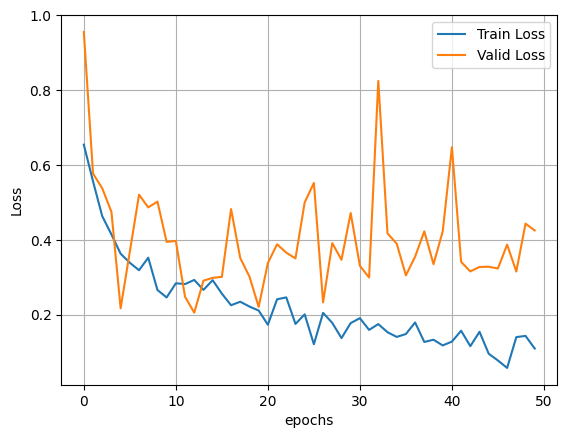

In [30]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

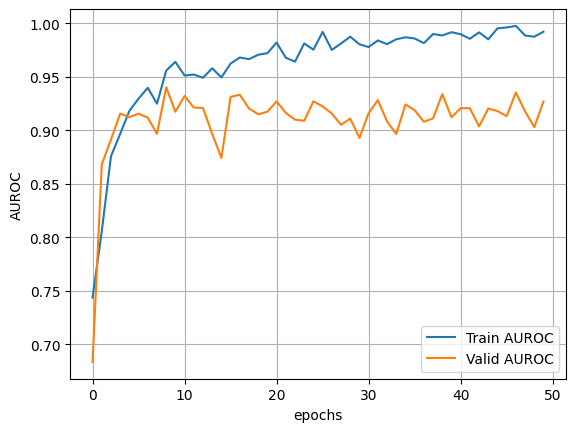

In [31]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

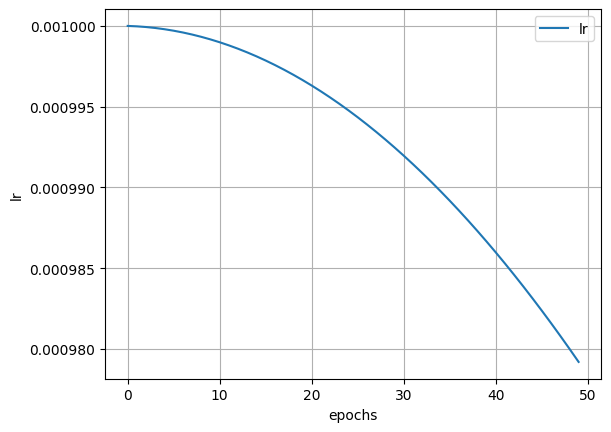

In [32]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()